# _*Qiskit Aqua: qGANs for Loading Random Distributions*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Christa Zoufal<sup>[1,2]</sup>, Stefan Woerner<sup>[1]</sup>
### Affliation
- <sup>[1]</sup>IBMQ
- <sup>[2]</sup>ETH Zurich

### Introduction
Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data's underlying random distribution and to load it directly into a quantum state: 
$$\lvert g_{\theta}\rangle = \sum\limits_{j=0}^{2^n-1}\sqrt{p_{\theta}^{j}}\lvert{j}\rangle$$
where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\vert j\rangle$. 

The aim of the qGAN training is to generate a state $\lvert g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to <a href="https://arxiv.org/abs/1904.00043">Quantum Generative Adversarial Networks for Learning and Loading Random Distributions. Zoufal, Lucchi, Woerner. 2019.</a>

In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import absolute_import, division, print_function

import numpy as np

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline


import time

start = time.time()

from torch import optim
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.components.uncertainty_models import UniformDistribution, UnivariateVariationalDistribution 
from qiskit.aqua.components.variational_forms import RY

from qiskit.aqua.algorithms.adaptive import QGAN
from qiskit.aqua.components.neural_networks.quantum_generator import QuantumGenerator
from qiskit.aqua.components.neural_networks.classical_discriminator import ClassicalDiscriminator, DiscriminatorNet

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.components.initial_states import Custom

from qiskit import BasicAer

### Load the Training Data
First, we need to load the $k$-dimensional training data samples (here k=1). <br/>
Next, the data resolution is set, i.e. the min/max data values and the number of qubits used to represent each data dimension.

In [2]:
# Number training data samples
N = 10000 

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0.,3.]) 
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

### Initialize the qGAN
The qGAN consists of a quantum generator $G_{\theta}$, a variational quantum circuit, and a classical discriminator $D_{\phi}$, a neural network. <br/>
To implement the quantum generator, we choose a depth-$1$ variational form that implements $R_Y$ rotations and $CZ$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should $>1$ becaue the higher the circuit depth the because higher circuit depths enable the representation of more complex structures.<br/>
The classical discriminator is given by a $3$-layer neural network that applies linear transformations, leaky ReLU functions in the hidden layers and a sigmoid function in the output layer. Notably, the neural network is implemented with PyTorch. Please refer to https://pytorch.org/get-started/locally/ for PyTorch installation instructions.<br/>
Here, both networks are updated with the ADAM optimization algorithm.

In [4]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 3000
# Batch size
batch_size = 1000

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),shots=batch_size, 
                                        circuit_caching=False)

# Set entangler map
entangler_map = [[0, 1]]


# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits), low=bounds[0], high=bounds[1])
q = QuantumRegister(sum(num_qubits), name='q')
qc = QuantumCircuit(q)
init_dist.build(qc, q)
init_distribution = Custom(num_qubits=sum(num_qubits), circuit=qc)
var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state = init_distribution, 
              entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.rand(var_form._num_parameters) * 2 * 1e-2
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, init_params,
                                              low=bounds[0], high=bounds[1])
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit)
# Set classical discriminator neural network
qgan.set_discriminator()

### Run the qGAN Training
During the training the discriminator's and the generator's parameters are updated alternately w.r.t the following loss functions:
$$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$
and
$$  L_D\left(\phi, \theta\right) =
	\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$
with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

In [5]:
# Run qGAN
qgan.run(quantum_instance)

# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

Epoch 1/3000...
Loss Discriminator:  0.6948
Loss Generator:  0.6307
Relative Entropy:  0.1998
Epoch 2/3000...
Loss Discriminator:  0.6919
Loss Generator:  0.6591
Relative Entropy:  0.1998
Epoch 3/3000...
Loss Discriminator:  0.6902
Loss Generator:  0.6836
Relative Entropy:  0.1997
Epoch 4/3000...
Loss Discriminator:  0.6892
Loss Generator:  0.7006
Relative Entropy:  0.1996
Epoch 5/3000...
Loss Discriminator:  0.6882
Loss Generator:  0.7083
Relative Entropy:  0.1996
Epoch 6/3000...
Loss Discriminator:  0.6877
Loss Generator:  0.7077
Relative Entropy:  0.1995
Epoch 7/3000...
Loss Discriminator:  0.6877
Loss Generator:  0.7024
Relative Entropy:  0.1995
Epoch 8/3000...
Loss Discriminator:  0.6853
Loss Generator:  0.6961
Relative Entropy:  0.1994
Epoch 9/3000...
Loss Discriminator:  0.6862
Loss Generator:  0.6931
Relative Entropy:  0.1993
Epoch 10/3000...
Loss Discriminator:  0.6846
Loss Generator:  0.6936
Relative Entropy:  0.1993
Epoch 11/3000...
Loss Discriminator:  0.6836
Loss Generator

Epoch 88/3000...
Loss Discriminator:  0.6663
Loss Generator:  0.7374
Relative Entropy:  0.1937
Epoch 89/3000...
Loss Discriminator:  0.6678
Loss Generator:  0.7366
Relative Entropy:  0.1936
Epoch 90/3000...
Loss Discriminator:  0.6666
Loss Generator:  0.7393
Relative Entropy:  0.1935
Epoch 91/3000...
Loss Discriminator:  0.6658
Loss Generator:  0.7414
Relative Entropy:  0.1935
Epoch 92/3000...
Loss Discriminator:  0.6665
Loss Generator:  0.7406
Relative Entropy:  0.1934
Epoch 93/3000...
Loss Discriminator:  0.6669
Loss Generator:  0.7369
Relative Entropy:  0.1933
Epoch 94/3000...
Loss Discriminator:  0.6671
Loss Generator:  0.7378
Relative Entropy:  0.1933
Epoch 95/3000...
Loss Discriminator:  0.6695
Loss Generator:  0.7396
Relative Entropy:  0.1932
Epoch 96/3000...
Loss Discriminator:  0.6652
Loss Generator:  0.7383
Relative Entropy:  0.1931
Epoch 97/3000...
Loss Discriminator:  0.6675
Loss Generator:  0.7392
Relative Entropy:  0.193
Epoch 98/3000...
Loss Discriminator:  0.6651
Loss G

Epoch 174/3000...
Loss Discriminator:  0.6674
Loss Generator:  0.7394
Relative Entropy:  0.1876
Epoch 175/3000...
Loss Discriminator:  0.6667
Loss Generator:  0.739
Relative Entropy:  0.1876
Epoch 176/3000...
Loss Discriminator:  0.662
Loss Generator:  0.7398
Relative Entropy:  0.1875
Epoch 177/3000...
Loss Discriminator:  0.6674
Loss Generator:  0.7406
Relative Entropy:  0.1874
Epoch 178/3000...
Loss Discriminator:  0.6656
Loss Generator:  0.741
Relative Entropy:  0.1874
Epoch 179/3000...
Loss Discriminator:  0.669
Loss Generator:  0.739
Relative Entropy:  0.1873
Epoch 180/3000...
Loss Discriminator:  0.6667
Loss Generator:  0.7379
Relative Entropy:  0.1872
Epoch 181/3000...
Loss Discriminator:  0.6661
Loss Generator:  0.7373
Relative Entropy:  0.1872
Epoch 182/3000...
Loss Discriminator:  0.6711
Loss Generator:  0.7389
Relative Entropy:  0.1871
Epoch 183/3000...
Loss Discriminator:  0.6653
Loss Generator:  0.7401
Relative Entropy:  0.187
Epoch 184/3000...
Loss Discriminator:  0.6652


Epoch 260/3000...
Loss Discriminator:  0.6677
Loss Generator:  0.7368
Relative Entropy:  0.1818
Epoch 261/3000...
Loss Discriminator:  0.6688
Loss Generator:  0.7372
Relative Entropy:  0.1817
Epoch 262/3000...
Loss Discriminator:  0.6697
Loss Generator:  0.7384
Relative Entropy:  0.1816
Epoch 263/3000...
Loss Discriminator:  0.6692
Loss Generator:  0.738
Relative Entropy:  0.1815
Epoch 264/3000...
Loss Discriminator:  0.6673
Loss Generator:  0.737
Relative Entropy:  0.1815
Epoch 265/3000...
Loss Discriminator:  0.6668
Loss Generator:  0.7368
Relative Entropy:  0.1814
Epoch 266/3000...
Loss Discriminator:  0.6679
Loss Generator:  0.7368
Relative Entropy:  0.1813
Epoch 267/3000...
Loss Discriminator:  0.6685
Loss Generator:  0.7393
Relative Entropy:  0.1813
Epoch 268/3000...
Loss Discriminator:  0.6699
Loss Generator:  0.739
Relative Entropy:  0.1812
Epoch 269/3000...
Loss Discriminator:  0.6664
Loss Generator:  0.7364
Relative Entropy:  0.1811
Epoch 270/3000...
Loss Discriminator:  0.66

Epoch 346/3000...
Loss Discriminator:  0.666
Loss Generator:  0.7348
Relative Entropy:  0.176
Epoch 347/3000...
Loss Discriminator:  0.67
Loss Generator:  0.7353
Relative Entropy:  0.1759
Epoch 348/3000...
Loss Discriminator:  0.671
Loss Generator:  0.7369
Relative Entropy:  0.1759
Epoch 349/3000...
Loss Discriminator:  0.6657
Loss Generator:  0.7367
Relative Entropy:  0.1758
Epoch 350/3000...
Loss Discriminator:  0.6701
Loss Generator:  0.7347
Relative Entropy:  0.1757
Epoch 351/3000...
Loss Discriminator:  0.6665
Loss Generator:  0.736
Relative Entropy:  0.1757
Epoch 352/3000...
Loss Discriminator:  0.6681
Loss Generator:  0.737
Relative Entropy:  0.1756
Epoch 353/3000...
Loss Discriminator:  0.6684
Loss Generator:  0.7358
Relative Entropy:  0.1755
Epoch 354/3000...
Loss Discriminator:  0.6668
Loss Generator:  0.7353
Relative Entropy:  0.1755
Epoch 355/3000...
Loss Discriminator:  0.6681
Loss Generator:  0.7349
Relative Entropy:  0.1754
Epoch 356/3000...
Loss Discriminator:  0.6693
L

Epoch 432/3000...
Loss Discriminator:  0.668
Loss Generator:  0.7343
Relative Entropy:  0.1704
Epoch 433/3000...
Loss Discriminator:  0.6699
Loss Generator:  0.7366
Relative Entropy:  0.1703
Epoch 434/3000...
Loss Discriminator:  0.6679
Loss Generator:  0.7358
Relative Entropy:  0.1703
Epoch 435/3000...
Loss Discriminator:  0.6688
Loss Generator:  0.7334
Relative Entropy:  0.1702
Epoch 436/3000...
Loss Discriminator:  0.6703
Loss Generator:  0.7319
Relative Entropy:  0.1701
Epoch 437/3000...
Loss Discriminator:  0.6685
Loss Generator:  0.7339
Relative Entropy:  0.1701
Epoch 438/3000...
Loss Discriminator:  0.6685
Loss Generator:  0.7366
Relative Entropy:  0.17
Epoch 439/3000...
Loss Discriminator:  0.6702
Loss Generator:  0.7344
Relative Entropy:  0.1699
Epoch 440/3000...
Loss Discriminator:  0.67
Loss Generator:  0.7348
Relative Entropy:  0.1699
Epoch 441/3000...
Loss Discriminator:  0.6695
Loss Generator:  0.7353
Relative Entropy:  0.1698
Epoch 442/3000...
Loss Discriminator:  0.6696

Epoch 518/3000...
Loss Discriminator:  0.672
Loss Generator:  0.7336
Relative Entropy:  0.1649
Epoch 519/3000...
Loss Discriminator:  0.6701
Loss Generator:  0.7307
Relative Entropy:  0.1649
Epoch 520/3000...
Loss Discriminator:  0.6688
Loss Generator:  0.7318
Relative Entropy:  0.1648
Epoch 521/3000...
Loss Discriminator:  0.6694
Loss Generator:  0.7335
Relative Entropy:  0.1647
Epoch 522/3000...
Loss Discriminator:  0.6711
Loss Generator:  0.7359
Relative Entropy:  0.1647
Epoch 523/3000...
Loss Discriminator:  0.6681
Loss Generator:  0.7307
Relative Entropy:  0.1646
Epoch 524/3000...
Loss Discriminator:  0.669
Loss Generator:  0.7335
Relative Entropy:  0.1645
Epoch 525/3000...
Loss Discriminator:  0.6693
Loss Generator:  0.7336
Relative Entropy:  0.1645
Epoch 526/3000...
Loss Discriminator:  0.6703
Loss Generator:  0.7328
Relative Entropy:  0.1644
Epoch 527/3000...
Loss Discriminator:  0.6679
Loss Generator:  0.7317
Relative Entropy:  0.1644
Epoch 528/3000...
Loss Discriminator:  0.6

Epoch 604/3000...
Loss Discriminator:  0.6717
Loss Generator:  0.7317
Relative Entropy:  0.1596
Epoch 605/3000...
Loss Discriminator:  0.6718
Loss Generator:  0.7332
Relative Entropy:  0.1595
Epoch 606/3000...
Loss Discriminator:  0.6688
Loss Generator:  0.7313
Relative Entropy:  0.1595
Epoch 607/3000...
Loss Discriminator:  0.6702
Loss Generator:  0.7301
Relative Entropy:  0.1594
Epoch 608/3000...
Loss Discriminator:  0.6702
Loss Generator:  0.7313
Relative Entropy:  0.1593
Epoch 609/3000...
Loss Discriminator:  0.67
Loss Generator:  0.7325
Relative Entropy:  0.1593
Epoch 610/3000...
Loss Discriminator:  0.6698
Loss Generator:  0.7293
Relative Entropy:  0.1592
Epoch 611/3000...
Loss Discriminator:  0.6703
Loss Generator:  0.7296
Relative Entropy:  0.1592
Epoch 612/3000...
Loss Discriminator:  0.6696
Loss Generator:  0.7341
Relative Entropy:  0.1591
Epoch 613/3000...
Loss Discriminator:  0.6731
Loss Generator:  0.7309
Relative Entropy:  0.159
Epoch 614/3000...
Loss Discriminator:  0.67

Epoch 690/3000...
Loss Discriminator:  0.6706
Loss Generator:  0.7295
Relative Entropy:  0.1544
Epoch 691/3000...
Loss Discriminator:  0.6688
Loss Generator:  0.7287
Relative Entropy:  0.1543
Epoch 692/3000...
Loss Discriminator:  0.6692
Loss Generator:  0.73
Relative Entropy:  0.1543
Epoch 693/3000...
Loss Discriminator:  0.6687
Loss Generator:  0.7306
Relative Entropy:  0.1542
Epoch 694/3000...
Loss Discriminator:  0.6697
Loss Generator:  0.7291
Relative Entropy:  0.1542
Epoch 695/3000...
Loss Discriminator:  0.6737
Loss Generator:  0.7284
Relative Entropy:  0.1541
Epoch 696/3000...
Loss Discriminator:  0.6739
Loss Generator:  0.7287
Relative Entropy:  0.154
Epoch 697/3000...
Loss Discriminator:  0.6736
Loss Generator:  0.7302
Relative Entropy:  0.154
Epoch 698/3000...
Loss Discriminator:  0.6733
Loss Generator:  0.7284
Relative Entropy:  0.1539
Epoch 699/3000...
Loss Discriminator:  0.6691
Loss Generator:  0.7297
Relative Entropy:  0.1539
Epoch 700/3000...
Loss Discriminator:  0.672

Epoch 776/3000...
Loss Discriminator:  0.6714
Loss Generator:  0.7272
Relative Entropy:  0.1493
Epoch 777/3000...
Loss Discriminator:  0.67
Loss Generator:  0.7303
Relative Entropy:  0.1493
Epoch 778/3000...
Loss Discriminator:  0.6717
Loss Generator:  0.7288
Relative Entropy:  0.1492
Epoch 779/3000...
Loss Discriminator:  0.6726
Loss Generator:  0.7287
Relative Entropy:  0.1492
Epoch 780/3000...
Loss Discriminator:  0.6715
Loss Generator:  0.7282
Relative Entropy:  0.1491
Epoch 781/3000...
Loss Discriminator:  0.67
Loss Generator:  0.7286
Relative Entropy:  0.149
Epoch 782/3000...
Loss Discriminator:  0.6741
Loss Generator:  0.7298
Relative Entropy:  0.149
Epoch 783/3000...
Loss Discriminator:  0.6751
Loss Generator:  0.7283
Relative Entropy:  0.1489
Epoch 784/3000...
Loss Discriminator:  0.6723
Loss Generator:  0.7279
Relative Entropy:  0.1489
Epoch 785/3000...
Loss Discriminator:  0.6698
Loss Generator:  0.7295
Relative Entropy:  0.1488
Epoch 786/3000...
Loss Discriminator:  0.671
L

Epoch 862/3000...
Loss Discriminator:  0.6747
Loss Generator:  0.7252
Relative Entropy:  0.1444
Epoch 863/3000...
Loss Discriminator:  0.6712
Loss Generator:  0.7272
Relative Entropy:  0.1444
Epoch 864/3000...
Loss Discriminator:  0.6718
Loss Generator:  0.7263
Relative Entropy:  0.1443
Epoch 865/3000...
Loss Discriminator:  0.6742
Loss Generator:  0.725
Relative Entropy:  0.1443
Epoch 866/3000...
Loss Discriminator:  0.673
Loss Generator:  0.7275
Relative Entropy:  0.1442
Epoch 867/3000...
Loss Discriminator:  0.6716
Loss Generator:  0.7267
Relative Entropy:  0.1441
Epoch 868/3000...
Loss Discriminator:  0.6743
Loss Generator:  0.727
Relative Entropy:  0.1441
Epoch 869/3000...
Loss Discriminator:  0.6731
Loss Generator:  0.7243
Relative Entropy:  0.144
Epoch 870/3000...
Loss Discriminator:  0.6718
Loss Generator:  0.7278
Relative Entropy:  0.144
Epoch 871/3000...
Loss Discriminator:  0.6727
Loss Generator:  0.7291
Relative Entropy:  0.1439
Epoch 872/3000...
Loss Discriminator:  0.6742

Epoch 948/3000...
Loss Discriminator:  0.675
Loss Generator:  0.7268
Relative Entropy:  0.1396
Epoch 949/3000...
Loss Discriminator:  0.6737
Loss Generator:  0.7239
Relative Entropy:  0.1396
Epoch 950/3000...
Loss Discriminator:  0.6742
Loss Generator:  0.7263
Relative Entropy:  0.1395
Epoch 951/3000...
Loss Discriminator:  0.6739
Loss Generator:  0.7286
Relative Entropy:  0.1395
Epoch 952/3000...
Loss Discriminator:  0.674
Loss Generator:  0.7258
Relative Entropy:  0.1394
Epoch 953/3000...
Loss Discriminator:  0.6723
Loss Generator:  0.7223
Relative Entropy:  0.1394
Epoch 954/3000...
Loss Discriminator:  0.6736
Loss Generator:  0.7238
Relative Entropy:  0.1393
Epoch 955/3000...
Loss Discriminator:  0.6719
Loss Generator:  0.7247
Relative Entropy:  0.1393
Epoch 956/3000...
Loss Discriminator:  0.6728
Loss Generator:  0.7275
Relative Entropy:  0.1392
Epoch 957/3000...
Loss Discriminator:  0.6766
Loss Generator:  0.7233
Relative Entropy:  0.1392
Epoch 958/3000...
Loss Discriminator:  0.6

Epoch 1034/3000...
Loss Discriminator:  0.6737
Loss Generator:  0.7241
Relative Entropy:  0.135
Epoch 1035/3000...
Loss Discriminator:  0.6749
Loss Generator:  0.7201
Relative Entropy:  0.1349
Epoch 1036/3000...
Loss Discriminator:  0.6717
Loss Generator:  0.7232
Relative Entropy:  0.1349
Epoch 1037/3000...
Loss Discriminator:  0.6735
Loss Generator:  0.7242
Relative Entropy:  0.1348
Epoch 1038/3000...
Loss Discriminator:  0.6756
Loss Generator:  0.7214
Relative Entropy:  0.1348
Epoch 1039/3000...
Loss Discriminator:  0.6769
Loss Generator:  0.7205
Relative Entropy:  0.1347
Epoch 1040/3000...
Loss Discriminator:  0.6735
Loss Generator:  0.7263
Relative Entropy:  0.1347
Epoch 1041/3000...
Loss Discriminator:  0.674
Loss Generator:  0.7277
Relative Entropy:  0.1346
Epoch 1042/3000...
Loss Discriminator:  0.6743
Loss Generator:  0.7222
Relative Entropy:  0.1346
Epoch 1043/3000...
Loss Discriminator:  0.6761
Loss Generator:  0.7221
Relative Entropy:  0.1345
Epoch 1044/3000...
Loss Discrimi

Epoch 1119/3000...
Loss Discriminator:  0.6775
Loss Generator:  0.7253
Relative Entropy:  0.1305
Epoch 1120/3000...
Loss Discriminator:  0.6742
Loss Generator:  0.7221
Relative Entropy:  0.1305
Epoch 1121/3000...
Loss Discriminator:  0.6752
Loss Generator:  0.718
Relative Entropy:  0.1304
Epoch 1122/3000...
Loss Discriminator:  0.6743
Loss Generator:  0.721
Relative Entropy:  0.1304
Epoch 1123/3000...
Loss Discriminator:  0.6758
Loss Generator:  0.7246
Relative Entropy:  0.1303
Epoch 1124/3000...
Loss Discriminator:  0.6746
Loss Generator:  0.7197
Relative Entropy:  0.1303
Epoch 1125/3000...
Loss Discriminator:  0.675
Loss Generator:  0.7232
Relative Entropy:  0.1302
Epoch 1126/3000...
Loss Discriminator:  0.6749
Loss Generator:  0.7247
Relative Entropy:  0.1302
Epoch 1127/3000...
Loss Discriminator:  0.6731
Loss Generator:  0.7222
Relative Entropy:  0.1301
Epoch 1128/3000...
Loss Discriminator:  0.6774
Loss Generator:  0.7241
Relative Entropy:  0.1301
Epoch 1129/3000...
Loss Discrimin

Epoch 1204/3000...
Loss Discriminator:  0.6739
Loss Generator:  0.7197
Relative Entropy:  0.1262
Epoch 1205/3000...
Loss Discriminator:  0.6767
Loss Generator:  0.719
Relative Entropy:  0.1262
Epoch 1206/3000...
Loss Discriminator:  0.6758
Loss Generator:  0.7199
Relative Entropy:  0.1261
Epoch 1207/3000...
Loss Discriminator:  0.6771
Loss Generator:  0.7197
Relative Entropy:  0.1261
Epoch 1208/3000...
Loss Discriminator:  0.6754
Loss Generator:  0.7224
Relative Entropy:  0.126
Epoch 1209/3000...
Loss Discriminator:  0.6757
Loss Generator:  0.7227
Relative Entropy:  0.126
Epoch 1210/3000...
Loss Discriminator:  0.6763
Loss Generator:  0.7194
Relative Entropy:  0.1259
Epoch 1211/3000...
Loss Discriminator:  0.6766
Loss Generator:  0.7244
Relative Entropy:  0.1259
Epoch 1212/3000...
Loss Discriminator:  0.6736
Loss Generator:  0.7198
Relative Entropy:  0.1258
Epoch 1213/3000...
Loss Discriminator:  0.676
Loss Generator:  0.7212
Relative Entropy:  0.1258
Epoch 1214/3000...
Loss Discrimina

Epoch 1289/3000...
Loss Discriminator:  0.6761
Loss Generator:  0.7184
Relative Entropy:  0.122
Epoch 1290/3000...
Loss Discriminator:  0.6772
Loss Generator:  0.7217
Relative Entropy:  0.1219
Epoch 1291/3000...
Loss Discriminator:  0.6768
Loss Generator:  0.7203
Relative Entropy:  0.1219
Epoch 1292/3000...
Loss Discriminator:  0.6739
Loss Generator:  0.7185
Relative Entropy:  0.1218
Epoch 1293/3000...
Loss Discriminator:  0.6776
Loss Generator:  0.719
Relative Entropy:  0.1218
Epoch 1294/3000...
Loss Discriminator:  0.6768
Loss Generator:  0.7213
Relative Entropy:  0.1217
Epoch 1295/3000...
Loss Discriminator:  0.6764
Loss Generator:  0.7225
Relative Entropy:  0.1217
Epoch 1296/3000...
Loss Discriminator:  0.6749
Loss Generator:  0.7178
Relative Entropy:  0.1216
Epoch 1297/3000...
Loss Discriminator:  0.676
Loss Generator:  0.7192
Relative Entropy:  0.1216
Epoch 1298/3000...
Loss Discriminator:  0.6767
Loss Generator:  0.7193
Relative Entropy:  0.1215
Epoch 1299/3000...
Loss Discrimin

Epoch 1374/3000...
Loss Discriminator:  0.6753
Loss Generator:  0.7177
Relative Entropy:  0.1175
Epoch 1375/3000...
Loss Discriminator:  0.6777
Loss Generator:  0.7166
Relative Entropy:  0.1174
Epoch 1376/3000...
Loss Discriminator:  0.6777
Loss Generator:  0.7185
Relative Entropy:  0.1174
Epoch 1377/3000...
Loss Discriminator:  0.6766
Loss Generator:  0.718
Relative Entropy:  0.1173
Epoch 1378/3000...
Loss Discriminator:  0.6777
Loss Generator:  0.7207
Relative Entropy:  0.1173
Epoch 1379/3000...
Loss Discriminator:  0.6742
Loss Generator:  0.718
Relative Entropy:  0.1172
Epoch 1380/3000...
Loss Discriminator:  0.6776
Loss Generator:  0.7182
Relative Entropy:  0.1172
Epoch 1381/3000...
Loss Discriminator:  0.6761
Loss Generator:  0.7199
Relative Entropy:  0.1171
Epoch 1382/3000...
Loss Discriminator:  0.6749
Loss Generator:  0.7171
Relative Entropy:  0.117
Epoch 1383/3000...
Loss Discriminator:  0.6778
Loss Generator:  0.7176
Relative Entropy:  0.117
Epoch 1384/3000...
Loss Discrimina

Epoch 1459/3000...
Loss Discriminator:  0.6774
Loss Generator:  0.7226
Relative Entropy:  0.1129
Epoch 1460/3000...
Loss Discriminator:  0.6792
Loss Generator:  0.7194
Relative Entropy:  0.1129
Epoch 1461/3000...
Loss Discriminator:  0.6786
Loss Generator:  0.7127
Relative Entropy:  0.1128
Epoch 1462/3000...
Loss Discriminator:  0.6766
Loss Generator:  0.7152
Relative Entropy:  0.1128
Epoch 1463/3000...
Loss Discriminator:  0.679
Loss Generator:  0.7221
Relative Entropy:  0.1127
Epoch 1464/3000...
Loss Discriminator:  0.677
Loss Generator:  0.7185
Relative Entropy:  0.1127
Epoch 1465/3000...
Loss Discriminator:  0.6786
Loss Generator:  0.7165
Relative Entropy:  0.1126
Epoch 1466/3000...
Loss Discriminator:  0.6772
Loss Generator:  0.7174
Relative Entropy:  0.1126
Epoch 1467/3000...
Loss Discriminator:  0.6771
Loss Generator:  0.7186
Relative Entropy:  0.1125
Epoch 1468/3000...
Loss Discriminator:  0.6778
Loss Generator:  0.7162
Relative Entropy:  0.1124
Epoch 1469/3000...
Loss Discrimi

Epoch 1544/3000...
Loss Discriminator:  0.6794
Loss Generator:  0.7194
Relative Entropy:  0.1084
Epoch 1545/3000...
Loss Discriminator:  0.679
Loss Generator:  0.7169
Relative Entropy:  0.1084
Epoch 1546/3000...
Loss Discriminator:  0.6799
Loss Generator:  0.7141
Relative Entropy:  0.1083
Epoch 1547/3000...
Loss Discriminator:  0.6778
Loss Generator:  0.7191
Relative Entropy:  0.1083
Epoch 1548/3000...
Loss Discriminator:  0.6786
Loss Generator:  0.7191
Relative Entropy:  0.1082
Epoch 1549/3000...
Loss Discriminator:  0.6792
Loss Generator:  0.7161
Relative Entropy:  0.1082
Epoch 1550/3000...
Loss Discriminator:  0.6773
Loss Generator:  0.7146
Relative Entropy:  0.1081
Epoch 1551/3000...
Loss Discriminator:  0.6798
Loss Generator:  0.7149
Relative Entropy:  0.1081
Epoch 1552/3000...
Loss Discriminator:  0.6773
Loss Generator:  0.7173
Relative Entropy:  0.108
Epoch 1553/3000...
Loss Discriminator:  0.6795
Loss Generator:  0.7182
Relative Entropy:  0.108
Epoch 1554/3000...
Loss Discrimin

Epoch 1629/3000...
Loss Discriminator:  0.6798
Loss Generator:  0.7153
Relative Entropy:  0.104
Epoch 1630/3000...
Loss Discriminator:  0.6795
Loss Generator:  0.7151
Relative Entropy:  0.104
Epoch 1631/3000...
Loss Discriminator:  0.6804
Loss Generator:  0.7138
Relative Entropy:  0.1039
Epoch 1632/3000...
Loss Discriminator:  0.6784
Loss Generator:  0.7151
Relative Entropy:  0.1038
Epoch 1633/3000...
Loss Discriminator:  0.6788
Loss Generator:  0.7154
Relative Entropy:  0.1038
Epoch 1634/3000...
Loss Discriminator:  0.6784
Loss Generator:  0.714
Relative Entropy:  0.1037
Epoch 1635/3000...
Loss Discriminator:  0.6802
Loss Generator:  0.7155
Relative Entropy:  0.1037
Epoch 1636/3000...
Loss Discriminator:  0.6799
Loss Generator:  0.7164
Relative Entropy:  0.1036
Epoch 1637/3000...
Loss Discriminator:  0.6789
Loss Generator:  0.7168
Relative Entropy:  0.1036
Epoch 1638/3000...
Loss Discriminator:  0.6786
Loss Generator:  0.7149
Relative Entropy:  0.1035
Epoch 1639/3000...
Loss Discrimin

Epoch 1714/3000...
Loss Discriminator:  0.6809
Loss Generator:  0.7168
Relative Entropy:  0.0997
Epoch 1715/3000...
Loss Discriminator:  0.6796
Loss Generator:  0.7178
Relative Entropy:  0.0996
Epoch 1716/3000...
Loss Discriminator:  0.6801
Loss Generator:  0.7111
Relative Entropy:  0.0996
Epoch 1717/3000...
Loss Discriminator:  0.6807
Loss Generator:  0.715
Relative Entropy:  0.0995
Epoch 1718/3000...
Loss Discriminator:  0.6806
Loss Generator:  0.7154
Relative Entropy:  0.0995
Epoch 1719/3000...
Loss Discriminator:  0.6813
Loss Generator:  0.7158
Relative Entropy:  0.0994
Epoch 1720/3000...
Loss Discriminator:  0.6795
Loss Generator:  0.7138
Relative Entropy:  0.0994
Epoch 1721/3000...
Loss Discriminator:  0.6797
Loss Generator:  0.7129
Relative Entropy:  0.0993
Epoch 1722/3000...
Loss Discriminator:  0.6795
Loss Generator:  0.7133
Relative Entropy:  0.0993
Epoch 1723/3000...
Loss Discriminator:  0.6813
Loss Generator:  0.7164
Relative Entropy:  0.0992
Epoch 1724/3000...
Loss Discrim

Epoch 1799/3000...
Loss Discriminator:  0.6799
Loss Generator:  0.7139
Relative Entropy:  0.0954
Epoch 1800/3000...
Loss Discriminator:  0.6795
Loss Generator:  0.7123
Relative Entropy:  0.0954
Epoch 1801/3000...
Loss Discriminator:  0.6806
Loss Generator:  0.7125
Relative Entropy:  0.0953
Epoch 1802/3000...
Loss Discriminator:  0.6795
Loss Generator:  0.7152
Relative Entropy:  0.0953
Epoch 1803/3000...
Loss Discriminator:  0.6822
Loss Generator:  0.7155
Relative Entropy:  0.0952
Epoch 1804/3000...
Loss Discriminator:  0.681
Loss Generator:  0.7142
Relative Entropy:  0.0952
Epoch 1805/3000...
Loss Discriminator:  0.6809
Loss Generator:  0.7126
Relative Entropy:  0.0951
Epoch 1806/3000...
Loss Discriminator:  0.6805
Loss Generator:  0.7138
Relative Entropy:  0.0951
Epoch 1807/3000...
Loss Discriminator:  0.6801
Loss Generator:  0.7138
Relative Entropy:  0.095
Epoch 1808/3000...
Loss Discriminator:  0.6797
Loss Generator:  0.7138
Relative Entropy:  0.095
Epoch 1809/3000...
Loss Discrimin

Epoch 1884/3000...
Loss Discriminator:  0.6818
Loss Generator:  0.7143
Relative Entropy:  0.0913
Epoch 1885/3000...
Loss Discriminator:  0.6805
Loss Generator:  0.7122
Relative Entropy:  0.0912
Epoch 1886/3000...
Loss Discriminator:  0.6808
Loss Generator:  0.7109
Relative Entropy:  0.0912
Epoch 1887/3000...
Loss Discriminator:  0.6822
Loss Generator:  0.7133
Relative Entropy:  0.0911
Epoch 1888/3000...
Loss Discriminator:  0.6807
Loss Generator:  0.7122
Relative Entropy:  0.0911
Epoch 1889/3000...
Loss Discriminator:  0.6813
Loss Generator:  0.7123
Relative Entropy:  0.0911
Epoch 1890/3000...
Loss Discriminator:  0.6811
Loss Generator:  0.7135
Relative Entropy:  0.091
Epoch 1891/3000...
Loss Discriminator:  0.6813
Loss Generator:  0.7148
Relative Entropy:  0.091
Epoch 1892/3000...
Loss Discriminator:  0.6793
Loss Generator:  0.7115
Relative Entropy:  0.0909
Epoch 1893/3000...
Loss Discriminator:  0.6806
Loss Generator:  0.7109
Relative Entropy:  0.0909
Epoch 1894/3000...
Loss Discrimi

Epoch 1969/3000...
Loss Discriminator:  0.681
Loss Generator:  0.7103
Relative Entropy:  0.0873
Epoch 1970/3000...
Loss Discriminator:  0.682
Loss Generator:  0.7135
Relative Entropy:  0.0872
Epoch 1971/3000...
Loss Discriminator:  0.6819
Loss Generator:  0.7152
Relative Entropy:  0.0872
Epoch 1972/3000...
Loss Discriminator:  0.681
Loss Generator:  0.7086
Relative Entropy:  0.0871
Epoch 1973/3000...
Loss Discriminator:  0.6822
Loss Generator:  0.7083
Relative Entropy:  0.0871
Epoch 1974/3000...
Loss Discriminator:  0.6816
Loss Generator:  0.7131
Relative Entropy:  0.087
Epoch 1975/3000...
Loss Discriminator:  0.6818
Loss Generator:  0.7142
Relative Entropy:  0.087
Epoch 1976/3000...
Loss Discriminator:  0.6819
Loss Generator:  0.7136
Relative Entropy:  0.0869
Epoch 1977/3000...
Loss Discriminator:  0.6825
Loss Generator:  0.7133
Relative Entropy:  0.0869
Epoch 1978/3000...
Loss Discriminator:  0.6803
Loss Generator:  0.7104
Relative Entropy:  0.0868
Epoch 1979/3000...
Loss Discriminat

Epoch 2054/3000...
Loss Discriminator:  0.6817
Loss Generator:  0.7105
Relative Entropy:  0.0833
Epoch 2055/3000...
Loss Discriminator:  0.681
Loss Generator:  0.7105
Relative Entropy:  0.0833
Epoch 2056/3000...
Loss Discriminator:  0.6821
Loss Generator:  0.7133
Relative Entropy:  0.0832
Epoch 2057/3000...
Loss Discriminator:  0.6815
Loss Generator:  0.7083
Relative Entropy:  0.0832
Epoch 2058/3000...
Loss Discriminator:  0.6816
Loss Generator:  0.7078
Relative Entropy:  0.0831
Epoch 2059/3000...
Loss Discriminator:  0.6809
Loss Generator:  0.7127
Relative Entropy:  0.0831
Epoch 2060/3000...
Loss Discriminator:  0.6817
Loss Generator:  0.7118
Relative Entropy:  0.083
Epoch 2061/3000...
Loss Discriminator:  0.6832
Loss Generator:  0.7097
Relative Entropy:  0.083
Epoch 2062/3000...
Loss Discriminator:  0.6832
Loss Generator:  0.712
Relative Entropy:  0.083
Epoch 2063/3000...
Loss Discriminator:  0.6833
Loss Generator:  0.7115
Relative Entropy:  0.0829
Epoch 2064/3000...
Loss Discriminat

Epoch 2139/3000...
Loss Discriminator:  0.6833
Loss Generator:  0.7111
Relative Entropy:  0.0795
Epoch 2140/3000...
Loss Discriminator:  0.683
Loss Generator:  0.7075
Relative Entropy:  0.0794
Epoch 2141/3000...
Loss Discriminator:  0.6813
Loss Generator:  0.7088
Relative Entropy:  0.0794
Epoch 2142/3000...
Loss Discriminator:  0.6823
Loss Generator:  0.7123
Relative Entropy:  0.0794
Epoch 2143/3000...
Loss Discriminator:  0.6823
Loss Generator:  0.7096
Relative Entropy:  0.0793
Epoch 2144/3000...
Loss Discriminator:  0.6832
Loss Generator:  0.7084
Relative Entropy:  0.0793
Epoch 2145/3000...
Loss Discriminator:  0.6828
Loss Generator:  0.7102
Relative Entropy:  0.0792
Epoch 2146/3000...
Loss Discriminator:  0.6828
Loss Generator:  0.7109
Relative Entropy:  0.0792
Epoch 2147/3000...
Loss Discriminator:  0.6823
Loss Generator:  0.7089
Relative Entropy:  0.0791
Epoch 2148/3000...
Loss Discriminator:  0.6811
Loss Generator:  0.709
Relative Entropy:  0.0791
Epoch 2149/3000...
Loss Discrimi

Epoch 2224/3000...
Loss Discriminator:  0.6844
Loss Generator:  0.7124
Relative Entropy:  0.0758
Epoch 2225/3000...
Loss Discriminator:  0.6845
Loss Generator:  0.7093
Relative Entropy:  0.0757
Epoch 2226/3000...
Loss Discriminator:  0.6838
Loss Generator:  0.7069
Relative Entropy:  0.0757
Epoch 2227/3000...
Loss Discriminator:  0.6821
Loss Generator:  0.7093
Relative Entropy:  0.0756
Epoch 2228/3000...
Loss Discriminator:  0.6829
Loss Generator:  0.7089
Relative Entropy:  0.0756
Epoch 2229/3000...
Loss Discriminator:  0.6826
Loss Generator:  0.7062
Relative Entropy:  0.0755
Epoch 2230/3000...
Loss Discriminator:  0.6829
Loss Generator:  0.7115
Relative Entropy:  0.0755
Epoch 2231/3000...
Loss Discriminator:  0.6832
Loss Generator:  0.7107
Relative Entropy:  0.0755
Epoch 2232/3000...
Loss Discriminator:  0.6805
Loss Generator:  0.7078
Relative Entropy:  0.0754
Epoch 2233/3000...
Loss Discriminator:  0.6828
Loss Generator:  0.7066
Relative Entropy:  0.0754
Epoch 2234/3000...
Loss Discri

Epoch 2309/3000...
Loss Discriminator:  0.6829
Loss Generator:  0.7103
Relative Entropy:  0.0721
Epoch 2310/3000...
Loss Discriminator:  0.6826
Loss Generator:  0.7097
Relative Entropy:  0.0721
Epoch 2311/3000...
Loss Discriminator:  0.6829
Loss Generator:  0.706
Relative Entropy:  0.0721
Epoch 2312/3000...
Loss Discriminator:  0.6835
Loss Generator:  0.7071
Relative Entropy:  0.072
Epoch 2313/3000...
Loss Discriminator:  0.6832
Loss Generator:  0.71
Relative Entropy:  0.072
Epoch 2314/3000...
Loss Discriminator:  0.6829
Loss Generator:  0.7101
Relative Entropy:  0.0719
Epoch 2315/3000...
Loss Discriminator:  0.6835
Loss Generator:  0.7084
Relative Entropy:  0.0719
Epoch 2316/3000...
Loss Discriminator:  0.6823
Loss Generator:  0.7062
Relative Entropy:  0.0718
Epoch 2317/3000...
Loss Discriminator:  0.6846
Loss Generator:  0.7095
Relative Entropy:  0.0718
Epoch 2318/3000...
Loss Discriminator:  0.6845
Loss Generator:  0.7077
Relative Entropy:  0.0718
Epoch 2319/3000...
Loss Discriminat

Epoch 2394/3000...
Loss Discriminator:  0.6849
Loss Generator:  0.7068
Relative Entropy:  0.0686
Epoch 2395/3000...
Loss Discriminator:  0.6848
Loss Generator:  0.7055
Relative Entropy:  0.0686
Epoch 2396/3000...
Loss Discriminator:  0.6841
Loss Generator:  0.707
Relative Entropy:  0.0685
Epoch 2397/3000...
Loss Discriminator:  0.6855
Loss Generator:  0.7068
Relative Entropy:  0.0685
Epoch 2398/3000...
Loss Discriminator:  0.6854
Loss Generator:  0.709
Relative Entropy:  0.0685
Epoch 2399/3000...
Loss Discriminator:  0.6838
Loss Generator:  0.7099
Relative Entropy:  0.0684
Epoch 2400/3000...
Loss Discriminator:  0.686
Loss Generator:  0.7091
Relative Entropy:  0.0684
Epoch 2401/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.704
Relative Entropy:  0.0683
Epoch 2402/3000...
Loss Discriminator:  0.6847
Loss Generator:  0.7051
Relative Entropy:  0.0683
Epoch 2403/3000...
Loss Discriminator:  0.6842
Loss Generator:  0.7086
Relative Entropy:  0.0683
Epoch 2404/3000...
Loss Discrimina

Epoch 2479/3000...
Loss Discriminator:  0.6844
Loss Generator:  0.7083
Relative Entropy:  0.0652
Epoch 2480/3000...
Loss Discriminator:  0.6848
Loss Generator:  0.7086
Relative Entropy:  0.0652
Epoch 2481/3000...
Loss Discriminator:  0.6868
Loss Generator:  0.7049
Relative Entropy:  0.0651
Epoch 2482/3000...
Loss Discriminator:  0.6844
Loss Generator:  0.7064
Relative Entropy:  0.0651
Epoch 2483/3000...
Loss Discriminator:  0.6843
Loss Generator:  0.7097
Relative Entropy:  0.0651
Epoch 2484/3000...
Loss Discriminator:  0.6853
Loss Generator:  0.7058
Relative Entropy:  0.065
Epoch 2485/3000...
Loss Discriminator:  0.6845
Loss Generator:  0.7034
Relative Entropy:  0.065
Epoch 2486/3000...
Loss Discriminator:  0.6829
Loss Generator:  0.7049
Relative Entropy:  0.0649
Epoch 2487/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.7076
Relative Entropy:  0.0649
Epoch 2488/3000...
Loss Discriminator:  0.6849
Loss Generator:  0.7064
Relative Entropy:  0.0649
Epoch 2489/3000...
Loss Discrimi

Epoch 2564/3000...
Loss Discriminator:  0.6842
Loss Generator:  0.7081
Relative Entropy:  0.0619
Epoch 2565/3000...
Loss Discriminator:  0.6843
Loss Generator:  0.7057
Relative Entropy:  0.0619
Epoch 2566/3000...
Loss Discriminator:  0.6855
Loss Generator:  0.7052
Relative Entropy:  0.0618
Epoch 2567/3000...
Loss Discriminator:  0.6837
Loss Generator:  0.7083
Relative Entropy:  0.0618
Epoch 2568/3000...
Loss Discriminator:  0.6844
Loss Generator:  0.7055
Relative Entropy:  0.0618
Epoch 2569/3000...
Loss Discriminator:  0.6834
Loss Generator:  0.7029
Relative Entropy:  0.0617
Epoch 2570/3000...
Loss Discriminator:  0.6847
Loss Generator:  0.7084
Relative Entropy:  0.0617
Epoch 2571/3000...
Loss Discriminator:  0.6842
Loss Generator:  0.707
Relative Entropy:  0.0616
Epoch 2572/3000...
Loss Discriminator:  0.6842
Loss Generator:  0.7046
Relative Entropy:  0.0616
Epoch 2573/3000...
Loss Discriminator:  0.6853
Loss Generator:  0.7075
Relative Entropy:  0.0616
Epoch 2574/3000...
Loss Discrim

Epoch 2649/3000...
Loss Discriminator:  0.6846
Loss Generator:  0.705
Relative Entropy:  0.0587
Epoch 2650/3000...
Loss Discriminator:  0.6865
Loss Generator:  0.7054
Relative Entropy:  0.0587
Epoch 2651/3000...
Loss Discriminator:  0.6851
Loss Generator:  0.705
Relative Entropy:  0.0587
Epoch 2652/3000...
Loss Discriminator:  0.686
Loss Generator:  0.705
Relative Entropy:  0.0586
Epoch 2653/3000...
Loss Discriminator:  0.6851
Loss Generator:  0.7034
Relative Entropy:  0.0586
Epoch 2654/3000...
Loss Discriminator:  0.6854
Loss Generator:  0.7057
Relative Entropy:  0.0585
Epoch 2655/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.708
Relative Entropy:  0.0585
Epoch 2656/3000...
Loss Discriminator:  0.6867
Loss Generator:  0.7066
Relative Entropy:  0.0585
Epoch 2657/3000...
Loss Discriminator:  0.6852
Loss Generator:  0.7032
Relative Entropy:  0.0584
Epoch 2658/3000...
Loss Discriminator:  0.686
Loss Generator:  0.7045
Relative Entropy:  0.0584
Epoch 2659/3000...
Loss Discriminato

Epoch 2734/3000...
Loss Discriminator:  0.6852
Loss Generator:  0.7053
Relative Entropy:  0.0556
Epoch 2735/3000...
Loss Discriminator:  0.6872
Loss Generator:  0.7047
Relative Entropy:  0.0556
Epoch 2736/3000...
Loss Discriminator:  0.686
Loss Generator:  0.7053
Relative Entropy:  0.0556
Epoch 2737/3000...
Loss Discriminator:  0.686
Loss Generator:  0.7039
Relative Entropy:  0.0555
Epoch 2738/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.7052
Relative Entropy:  0.0555
Epoch 2739/3000...
Loss Discriminator:  0.6865
Loss Generator:  0.7035
Relative Entropy:  0.0555
Epoch 2740/3000...
Loss Discriminator:  0.6871
Loss Generator:  0.704
Relative Entropy:  0.0554
Epoch 2741/3000...
Loss Discriminator:  0.687
Loss Generator:  0.7058
Relative Entropy:  0.0554
Epoch 2742/3000...
Loss Discriminator:  0.6862
Loss Generator:  0.7035
Relative Entropy:  0.0554
Epoch 2743/3000...
Loss Discriminator:  0.687
Loss Generator:  0.704
Relative Entropy:  0.0553
Epoch 2744/3000...
Loss Discriminato

Epoch 2819/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.7059
Relative Entropy:  0.0527
Epoch 2820/3000...
Loss Discriminator:  0.6864
Loss Generator:  0.7028
Relative Entropy:  0.0526
Epoch 2821/3000...
Loss Discriminator:  0.6874
Loss Generator:  0.7009
Relative Entropy:  0.0526
Epoch 2822/3000...
Loss Discriminator:  0.6867
Loss Generator:  0.7038
Relative Entropy:  0.0526
Epoch 2823/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.7058
Relative Entropy:  0.0525
Epoch 2824/3000...
Loss Discriminator:  0.6857
Loss Generator:  0.7034
Relative Entropy:  0.0525
Epoch 2825/3000...
Loss Discriminator:  0.6868
Loss Generator:  0.7045
Relative Entropy:  0.0525
Epoch 2826/3000...
Loss Discriminator:  0.6861
Loss Generator:  0.7024
Relative Entropy:  0.0524
Epoch 2827/3000...
Loss Discriminator:  0.6872
Loss Generator:  0.7046
Relative Entropy:  0.0524
Epoch 2828/3000...
Loss Discriminator:  0.6863
Loss Generator:  0.7046
Relative Entropy:  0.0524
Epoch 2829/3000...
Loss Discri

Epoch 2904/3000...
Loss Discriminator:  0.6869
Loss Generator:  0.7032
Relative Entropy:  0.0498
Epoch 2905/3000...
Loss Discriminator:  0.6867
Loss Generator:  0.7039
Relative Entropy:  0.0498
Epoch 2906/3000...
Loss Discriminator:  0.6873
Loss Generator:  0.702
Relative Entropy:  0.0498
Epoch 2907/3000...
Loss Discriminator:  0.6872
Loss Generator:  0.702
Relative Entropy:  0.0497
Epoch 2908/3000...
Loss Discriminator:  0.6864
Loss Generator:  0.701
Relative Entropy:  0.0497
Epoch 2909/3000...
Loss Discriminator:  0.6863
Loss Generator:  0.7041
Relative Entropy:  0.0497
Epoch 2910/3000...
Loss Discriminator:  0.6865
Loss Generator:  0.7034
Relative Entropy:  0.0496
Epoch 2911/3000...
Loss Discriminator:  0.6879
Loss Generator:  0.7034
Relative Entropy:  0.0496
Epoch 2912/3000...
Loss Discriminator:  0.6873
Loss Generator:  0.703
Relative Entropy:  0.0496
Epoch 2913/3000...
Loss Discriminator:  0.6864
Loss Generator:  0.702
Relative Entropy:  0.0495
Epoch 2914/3000...
Loss Discriminat

Epoch 2989/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.7031
Relative Entropy:  0.0472
Epoch 2990/3000...
Loss Discriminator:  0.687
Loss Generator:  0.7028
Relative Entropy:  0.0471
Epoch 2991/3000...
Loss Discriminator:  0.6886
Loss Generator:  0.7016
Relative Entropy:  0.0471
Epoch 2992/3000...
Loss Discriminator:  0.6886
Loss Generator:  0.7015
Relative Entropy:  0.0471
Epoch 2993/3000...
Loss Discriminator:  0.6869
Loss Generator:  0.6996
Relative Entropy:  0.047
Epoch 2994/3000...
Loss Discriminator:  0.6872
Loss Generator:  0.7028
Relative Entropy:  0.047
Epoch 2995/3000...
Loss Discriminator:  0.6862
Loss Generator:  0.7063
Relative Entropy:  0.047
Epoch 2996/3000...
Loss Discriminator:  0.6877
Loss Generator:  0.703
Relative Entropy:  0.0469
Epoch 2997/3000...
Loss Discriminator:  0.6885
Loss Generator:  0.7009
Relative Entropy:  0.0469
Epoch 2998/3000...
Loss Discriminator:  0.6876
Loss Generator:  0.7018
Relative Entropy:  0.0469
Epoch 2999/3000...
Loss Discriminat

### Training Progress & Outcome
Now, we plot the evolution of the generator's and the discriminator's loss functions during the training as well as the progress in the relative entropy between the trained and the target distribution.
<br/> Finally, we also compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

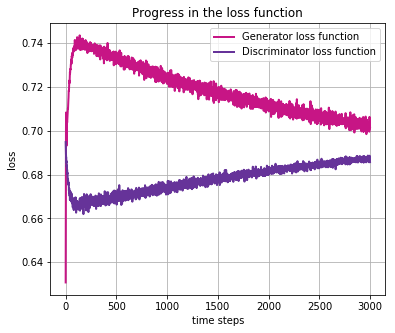

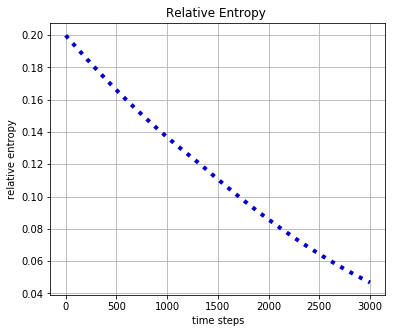

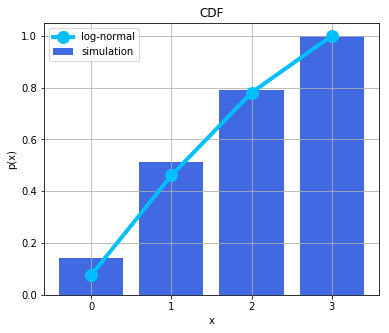

In [7]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()


# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

#Plot the PDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1]+1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title("CDF")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()